# A genetic algorithm to select mRNA sequences


In this notebook, we run a genetic algorithm to select sequences for wet-lab evaluation.

We use sequences from [mRNABert - Zenoda / pre-input.fasta](https://zenodo.org/records/15112690) as the initial sequence pool.

Install RNA-Fold.

In [1]:
#!conda config --add channels defaults
#!conda config --add channels bioconda
#!conda config --add channels conda-forge
#!conda config --set channel_priority strict
#!conda install viennarna

In [2]:
# !pip install matplotlib numpy tqdm seaborn "seqme[rnafm]==0.3.7"

In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import math

import matplotlib as mpl
import matplotlib.gridspec as gridspec

import seqme as sm
import re

In [4]:
np.random.seed(42)

In [8]:
WORKDIR_PATH = Path("./..")
WORKDIR_PATH = Path("./")

In [9]:
RAW_PATH = WORKDIR_PATH / "data" / "mrna_dna.fasta"

POOL_PATH = WORKDIR_PATH / "data" / "mrna.fasta"
CACHE_PATH = WORKDIR_PATH / "cache" / "pool.pkl"

TEMP_MRNA_DATA_PATH = WORKDIR_PATH / "data" / "mrna.txt"
RNAFOLD_OUT_PATH = WORKDIR_PATH / "data" / "rnafold_out.txt"

In [10]:
dna = sm.read_fasta(RAW_PATH)

In [11]:
def filter_sequences(sequences: list[str]) -> list[str]:
    NUCLEOTIDES_SET = set(list("ACGT"))
    return [
        sequence for sequence in sequences if len(set(sequence) - NUCLEOTIDES_SET) == 0
    ]


def to_rna(sequence: str) -> str:
    complement_map = str.maketrans("ATCG", "AUCG")
    return sequence.translate(complement_map)


In [12]:
dna = filter_sequences(dna)
rna = [to_rna(seq) for seq in dna]

In [13]:
sm.to_fasta(rna, POOL_PATH)

## RNA-Fold

Compute minimum-free energy using RNA-Fold.

In [14]:
sequences = sm.read_fasta(POOL_PATH)

In [15]:
path = Path(TEMP_MRNA_DATA_PATH)
path.parent.mkdir(parents=True, exist_ok=True)

with path.open("w") as f:
    for i, seq in enumerate(sequences):
        f.write(f"{seq}\n")

In [16]:
# !rnafold -i "{TEMP_MRNA_DATA_PATH}" > "{RNAFOLD_OUT_PATH}"

## Setup

In [17]:
POOL_SIZE = 12_000
BAG_SIZE = 1_000

N_ITERATIONS = 50_000
GENERATION_SIZE = 1

Let's load the pool into memory.

In [18]:
sequences = sm.read_fasta(POOL_PATH)
sequences = [seq for seq in sequences if len(seq) <= 1000]

pool = sm.utils.subsample(sequences, POOL_SIZE)

## Cache precomputing


Let's precompute the sequences in the cache immediately.


In [19]:
COMPUTE_CACHE = False

In [20]:
def extract_rna_fold(path: Path) -> list[tuple[str, float]]:
    def extract_free_energy(structure_line: str) -> tuple[str, float]:
        pattern = re.compile(r"(.+?)\s*\(\s*(-?\d+\.?\d*)\s*\)$", re.DOTALL)
        match = pattern.match(structure_line)
        if not match:
            raise ValueError(f"Invalid structure line: {structure_line}")
        structure = match.group(1)
        free_energy = float(match.group(2))
        return structure, free_energy

    with open(path) as f:
        text = f.read()
    lines = text.strip().split("\n")

    free_energy_pairs = []
    for sequence, structure_line in zip(lines[::2], lines[1::2], strict=True):
        _, free_energy = extract_free_energy(structure_line)
        free_energy_pairs.append((sequence, free_energy))

    return free_energy_pairs

In [21]:
if COMPUTE_CACHE:
    models = {"RNA-FM": sm.models.RNAFM(model_name="ncRNA", batch_size=64)}
    free_energy_pairs = extract_rna_fold(RNAFOLD_OUT_PATH)
    init_cache = {"free-energy": dict(free_energy_pairs)}
    cache = sm.Cache(models=models, init_cache=init_cache)

    for bag_name in tqdm(models.keys()):
        model = cache.model(bag_name)
        model(pool)

    sm.to_pickle(cache.get(), CACHE_PATH)

## Run


Let's load the cache.


In [22]:
precomputed = sm.read_pickle(CACHE_PATH)
cache = sm.Cache(init_cache=precomputed)

Let's define the metrics.


In [23]:
metrics = [
    sm.metrics.Count(),
    sm.metrics.Length(),
    sm.metrics.FKEA(cache.model("RNA-FM"), bandwidth=5.0, n_random_fourier_features=None, device="cuda"),
    sm.metrics.ID(cache.model("free-energy"), "Minimum free energy (kcal/mol)", "minimize"),
]

rank_by = ["FKEA", "Minimum free energy (kcal/mol)"]

Let's run the algorithm to select the bags of sequences.


In [24]:
def pile_sample(
    generation_size: int,
    bag_size: int,
    dfs: list[pd.DataFrame],
    indices_per_bag: np.ndarray,
    extra_indices: np.ndarray,
    *,
    extra_indices_frac: float = 0.0,
    history: int | None = 1,
    **kwargs,
) -> np.ndarray:
    dfs_history = dfs[-min(history, len(dfs)) :] if history is not None else dfs
    df = sm.combine(dfs_history)

    # df = sm.rank(df, metrics=rank_by, name="Rank (history)")
    # df_best = sm.top_k(df, "Rank (history)", k=1, keep="all")
    df_best = sm.extract_non_dominated(df, rank_by, level=0)

    best_pool = {int(idx) for bag in df_best.index for idx in indices_per_bag[bag]}
    extra_pool = set(extra_indices) - best_pool

    best_pool = list(best_pool)
    extra_pool = list(extra_pool)

    def sample_bag():
        extra_size = math.floor(extra_indices_frac * bag_size)
        if extra_size > 0:
            extra_selected_indices = np.random.choice(
                extra_pool, size=extra_size, replace=False
            )
        best_indices = np.random.choice(
            best_pool, size=bag_size - extra_size, replace=False
        )
        return (
            np.concat([best_indices, extra_selected_indices])
            if extra_size > 0
            else best_indices
        )

    return [sample_bag() for _ in range(generation_size)]


def crossover_sample(
    generation_size: int,
    bag_size: int,
    dfs: list[pd.DataFrame],
    indices_per_bag: np.ndarray,
    extra_indices: np.ndarray,
    *,
    extra_indices_frac: float = 0.0,
    min_best: int | None = None,
    history: int | None = 1,
    **kwargs,
) -> np.ndarray:
    dfs_history = dfs[-min(history, len(dfs)) :] if history is not None else dfs
    df = sm.combine(dfs_history)

    # df = sm.rank(df, metrics=rank_by, name="Rank (history)")
    # df_best = sm.top_k(df, "Rank (history)", k=1, keep="all")
    df_best = sm.extract_non_dominated(df, rank_by, level=0)

    if min_best and len(df_best) < min_best:
        df_best = sm.sort(df, "Rank (generation)")
        df_best = df_best.iloc[:min_best]

    best_pool = {int(idx) for bag in df_best.index for idx in indices_per_bag[bag]}
    extra_pool = set(extra_indices.tolist()) - best_pool

    best_pool = list(best_pool)
    extra_pool = list(extra_pool)

    def sample_bag():
        parent_ilocs = np.random.choice(np.arange(len(df_best)), size=2)
        parent_bags = df_best.index[parent_ilocs]
        parents_pool = {int(idx) for bag in parent_bags for idx in indices_per_bag[bag]}

        extra_size = math.floor(extra_indices_frac * bag_size)
        if extra_size > 0:
            extra_selected_indices = np.random.choice(
                extra_pool, size=extra_size, replace=False
            )
        parent_indices = np.random.choice(
            list(parents_pool), size=bag_size - extra_size, replace=False
        )
        return (
            np.concat([parent_indices, extra_selected_indices])
            if extra_size > 0
            else parent_indices
        )

    return [sample_bag() for _ in range(generation_size)]


def single_sample(
    generation_size: int,
    bag_size: int,
    dfs: list[pd.DataFrame],
    indices_per_bag: np.ndarray,
    extra_indices: np.ndarray,
    *,
    extra_indices_frac: float = 0.0,
    min_best: int | None = None,
    history: int | None = 1,
    **kwargs,
) -> np.ndarray:
    dfs_history = dfs[-min(history, len(dfs)) :] if history is not None else dfs
    df = sm.combine(dfs_history)

    # df = sm.rank(df, metrics=rank_by, name="Rank (history)")
    # df_best = sm.top_k(df, "Rank (history)", k=1, keep="all")
    df_best = sm.extract_non_dominated(df, rank_by, level=0)

    if min_best and len(df_best) < min_best:
        df_best = sm.sort(df, "Rank (history)")
        df_best = df_best.iloc[:min_best]

    best_pool = {int(idx) for bag in df_best.index for idx in indices_per_bag[bag]}
    extra_pool = set(extra_indices.tolist()) - best_pool

    best_pool = list(best_pool)
    extra_pool = list(extra_pool)

    def sample_bag():
        parent_iloc = np.random.choice(np.arange(len(df_best)))
        parent_bag = df_best.index[parent_iloc]
        parents_pool = {int(idx) for idx in indices_per_bag[parent_bag]}

        extra_size = math.floor(extra_indices_frac * bag_size)
        if extra_size > 0:
            extra_selected_indices = np.random.choice(
                extra_pool, size=extra_size, replace=False
            )
        parent_indices = np.random.choice(
            list(parents_pool), size=bag_size - extra_size, replace=False
        )
        return (
            np.concat([parent_indices, extra_selected_indices])
            if extra_size > 0
            else parent_indices
        )

    return [sample_bag() for _ in range(generation_size)]


def pool_sample(
    generation_size: int,
    bag_size: int,
    dfs: list[pd.DataFrame],
    indices_per_bag: np.ndarray,
    extra_indices: np.ndarray,
    **kwargs,
) -> np.ndarray:
    return [
        np.random.choice(extra_indices, size=bag_size) for _ in range(generation_size)
    ]


In [25]:
def decay(x: np.ndarray, N0: float, N1: float, k: float) -> np.ndarray:
    return N1 + (N0 - N1) * np.exp(-k * x)

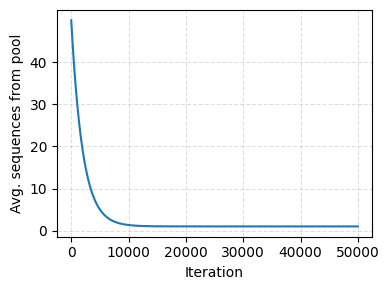

In [26]:
k = 0.0005
N0 = 0.05
N1 = 1 / BAG_SIZE

xs = np.arange(N_ITERATIONS)
ys = BAG_SIZE * decay(xs, N0=N0, N1=N1, k=k)

fig, ax = plt.subplots(figsize=(4, 3))
ax.grid(True, linestyle="--", alpha=0.4)
ax.plot(xs, ys)
ax.set_yticks(BAG_SIZE * np.arange(0, N0, 0.01))
ax.set_xlabel("Iteration")
ax.set_ylabel("Avg. sequences from pool")
fig.tight_layout()

In [ ]:
dfs = []
indices_per_bag = {}

extra_indices = np.arange(len(pool))

# First generation of bags
gen_bag_indices = [
    np.random.choice(extra_indices, size=BAG_SIZE, replace=False)
    for _ in range(GENERATION_SIZE)
]

for idx_iter in tqdm(range(N_ITERATIONS)):
    # Evaluate generation
    dfs_gen = []
    for idx_gen in range(GENERATION_SIZE):
        bag_indices = gen_bag_indices[idx_gen]
        bag_sequences = [pool[i] for i in bag_indices]

        bag_name = (idx_iter, idx_gen)
        indices_per_bag[bag_name] = bag_indices
        df_bag = sm.evaluate(
            sequences={bag_name: bag_sequences}, metrics=metrics, verbose=False
        )
        dfs_gen += [df_bag]

    # Combine and rank generation
    df_gen = sm.combine(dfs_gen)
    df_gen = sm.rank(df_gen, metrics=rank_by, name="Rank (generation)")
    dfs += [df_gen]

    # frac = np.interp(idx_iter / N_ITERATIONS, [0, 0.1, 1.0], [0.1, 0.025, 0.0])
    #frac = np.interp(idx_iter, [0, 300, N_ITERATIONS], [0.05, 0.02, 0.0])
    frac = decay(idx_iter, N0=N0, N1=N1, k=k)
    #frac = 0.03
    gen_bag_indices = single_sample(
        GENERATION_SIZE,
        BAG_SIZE,
        dfs,
        indices_per_bag,
        extra_indices,
        extra_indices_frac=frac,
        min_best=None,
        history=500,
    )

df = sm.combine(dfs)

 14%|█▎        | 6834/50000 [37:38<3:47:12,  3.17it/s] 

In [ ]:
df = sm.combine(dfs)

Let's compute the global rank.

In [ ]:
df = sm.rank(df, metrics=rank_by)

Let's display a subset of the bags.

In [ ]:
# sm.show(df, color="#fd82ff", level=1, color_style="bar")

In [ ]:
df_top_within = sm.top_k(df, "Rank (generation)", k=1, level=1)

df_top_within_single = sm.top_k(df, "Rank (generation)", k=1, level=1, keep="first")
df_top_within_single.index = pd.MultiIndex.from_tuples(
    [("Bag", i) for i in range(len(df_top_within_single))], names=["Bag", None]
)

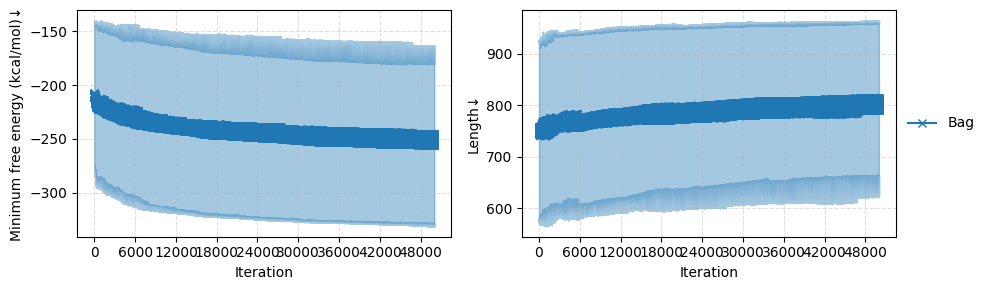

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
sm.plot_line(df_top_within_single, "Minimum free energy (kcal/mol)", ax=axes[0])
sm.plot_line(df_top_within_single, "Length", ax=axes[1])
axes[0].legend().set_visible(False)
fig.tight_layout()

In [ ]:
df_top_all = sm.top_k(df, "Rank", k=1)
df_top_free_energy = sm.top_k(df, "Minimum free energy (kcal/mol)", k=1)

bag_name = df_top_free_energy.index[-1]

bag_indices = indices_per_bag[bag_name]
bag_sequences = [pool[i] for i in bag_indices]

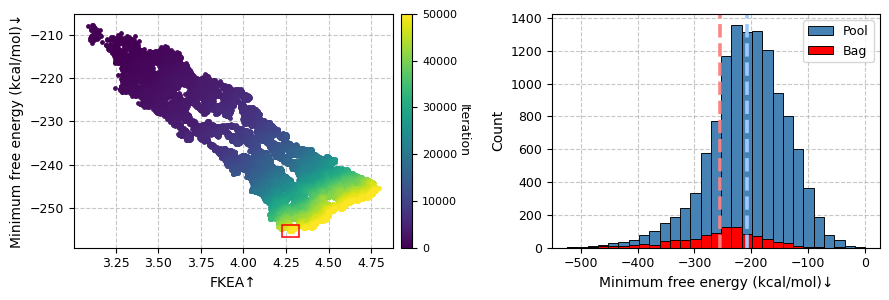

In [ ]:
fig = plt.figure(figsize=(9, 3.1))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.54, 0.46])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

## Genetic algorithm
ax = ax0

cmap = plt.get_cmap("viridis")
colors = [cmap(i / (N_ITERATIONS - 1)) for i in range(N_ITERATIONS)]

sm.plot_scatter(
    df_top_within,
    metrics=rank_by,
    marker=None,
    linestyle=None,
    show_deviation=False,
    marker_size=6,
    color=colors,
    ax=ax,
)
ax.legend().set_visible(False)
ax.tick_params(axis="both", labelsize=9)

norm = mpl.colors.Normalize(vmin=0, vmax=N_ITERATIONS)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, pad=0.02)
cbar.set_label("Iteration", rotation=270, va="center", fontsize=9)
cbar.ax.tick_params(labelsize=8)

df_min = df_top_within.min()
df_max = df_top_within.max()
ww = df_max[rank_by[0]]["value"] - df_min[rank_by[0]]["value"]
hh = df_max[rank_by[1]]["value"] - df_min[rank_by[1]]["value"]

vs = df_top_within.loc[bag_name]
v1 = vs[rank_by[0]]["value"]
v2 = vs[rank_by[1]]["value"]

size = 0.06
w, h = size * ww, size * hh
xy = (v1 - w / 2, v2 - h / 2)
edge_rect = mpl.patches.Rectangle(
    xy,
    w,
    h,
    linewidth=1.1,
    edgecolor="red",
    facecolor="none",
    alpha=1,
    zorder=10,
)
ax.add_patch(edge_rect)


## Distribution
ax = ax1

free_energy_fn = cache.model("free-energy")
vs1 = free_energy_fn(pool)
vs2 = free_energy_fn(bag_sequences)

all_data = np.concatenate([vs1, vs2])
bins = np.linspace(all_data.min(), all_data.max(), 30)

sns.histplot(vs1, ax=ax, alpha=1, label="Pool", bins=bins, color="steelblue")
sns.histplot(vs2, ax=ax, alpha=1, label="Bag", bins=bins, color="red")
ax.tick_params(axis="both", labelsize=9)

ax.axvline(np.mean(vs1), color="#9ec9ff", linestyle="--", linewidth=2.6)
ax.axvline(np.mean(vs2), color="#fb8282f6", linestyle="--", linewidth=2.6)

ax.set_xlabel("Minimum free energy (kcal/mol)↓")
ax.grid(axis="both", linestyle="--", alpha=0.7)
ax.set_axisbelow(True)
ax.legend(fontsize=9)

fig.tight_layout()
fig.savefig(WORKDIR_PATH / "figs/case3/both3.png", bbox_inches="tight", dpi=300)
